# Kinetic Energy Mean-Transient Decomposition

Decomposing the kinetic energy into time-mean and transient components.

## Theory

For a hydrostatic ocean model, like MOM5, the relevant kinetic energy per unit mass is 

$$ {\rm KE} = \frac{1}{2} (u^2 + v^2).$$

The vertical velocity component, $w$, does not appear in the mechanical energy budget. It is very much subdominant. But more fundamentally, it simply does not appear in the mechanical energy buget for a hydrostatic ocean. 

For a non-steady fluid, we can define the time-averaged kinetic energy as the __total kinetic energy__, TKE

$$ {\rm TKE} = \left< {\rm KE} \right > {\stackrel{\rm{def}}{=}} \frac{1}{T} \int_0^T \frac{1}{2} \left( u^2 + v^2 \right)\,\mathrm{d}t.$$

It is useful to decompose the velocity into time-mean and time-varying components, e.g.,

$$ u = \bar{u} + u'.$$

The __mean kinetic energy__ is the energy associated with the mean flow

$$ {\rm MKE} = \frac{1}{2} \left( \bar{u}^2 + \bar{v}^2 \right) $$

The kinetic energy of the time varying component is the __eddy kinetic energy__, EKE. This quantity can be obtained by 
substracting the velocity means and calculating the kinetic energy of the 
perturbation velocity quantities.

$$ {\rm EKE} =  \overline{ \frac{1}{2} \left[ \left(u - \overline{u}\right)^2 + \left(v - \overline{v}\right)^2 \right] } $$
                                 
MKE and EKE partition the total kinetic energy

$${\rm TKE} = {\rm MKE} + {\rm EKE}.$$


## Calculation


We start by importing some useful packages.

In [16]:
from esmvalcore.dataset import Dataset
from esmvalcore.preprocessor import (add_supplementary_variables,
    axis_statistics,
    regrid,
)
import iris

import cartopy.crs as ccrs
import cartopy.feature as feature
import numpy as np
import matplotlib.path as mpath

import matplotlib.pyplot as plt
import iris.plot as iplt
import cmocean as cm


In [17]:
from dask.distributed import Client

client = Client() #threads_per_worker = 1
client

INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:35253
INFO:distributed.scheduler:  dashboard at:         /proxy/8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34827'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35003'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:46825'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:38525'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42509'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43049'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43677'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:36947 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:36947
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:46990
INFO:distributed.schedule

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35253,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:37841,Total threads: 4
Dashboard: /proxy/43585/status,Memory: 18.00 GiB
Nanny: tcp://127.0.0.1:34827,


For this recipe we will just load 1 year of monthly velocities, but if you want to do the decomposition with output longer than, e.g., 1 year then we suggest you either convert this to a `.py` script and submit through the queue via `qsub` or figure a way to scale `dask` up to larger `ncpus`.

In [18]:

uOM2 = Dataset(short_name='uo', project='CMIP6',
    activity='OMIP', mip="Omon", exp="omip2",
    ensemble="r1i1p1f1", timerange="0306/0306",
    dataset="ACCESS-OM2-025", grid="gn")

# cell thickness: thkcello
uOM2.add_supplementary(short_name='thkcello', mip='Ofx')
# load thickness
thkcel = uOM2.supplementaries[0].load()

vOM2 = uOM2.copy(short_name='vo')

#load dataset
uOM2 = uOM2.load()
vOM2 = vOM2.load()

In [19]:
print(thkcel.summary(shorten=True))

cell_thickness / (m)                (depth: 50; cell index along second dimension: 1080; cell index along first dimension: 1440)


Define a plotting function:

In [20]:

def circumpolar_map():
    fig = plt.figure(figsize = (12, 8))
    ax = plt.axes(projection = ccrs.SouthPolarStereo())
    ax.set_extent([-180, 180, -80, -50], crs = ccrs.PlateCarree())
    ax.set_facecolor('lightgrey')
    # Map the plot boundaries to a circle
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform = ax.transAxes)

    return fig, ax

The kinetic energy is 

$$ {\rm KE} = \frac{1}{2} (u^2 + v^2).$$

We construct the following expression:

In [6]:
KEom2 = 0.5*(uOM2**2 + vOM2**2)

# add ancillary (thickness for depth)
KEom2 = add_supplementary_variables(KEom2, thkcel])

You may notice that this line runs instantly. The calculation is not (yet) computed. Rather, `xarray` needs to broadcast the squares of the velocity fields together to determine the final shape of KE. 

This is too large to store locally.  We need to reduce the data in some way.  

The mean kinetic energy is calculated by this function, which returns the depth integrated KE:

$$ \int_{z_0}^{z} \mathrm{KE}\,\mathrm{d}z.$$

Let's load the cell thickness ($dz$), and interpolate to the u-grid:

In [7]:
# mean time, sum depth
TKE = axis_statistics(KEom2, operator='mean', axis='t')
TKE = TKE.collapsed('depth', iris.analysis.SUM, weights='cell_thickness')
TKE = regrid(TKE, '0.5x0.5', scheme='linear')


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/numpy/ma/core.py:6980: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/numpy/ma/core.py:6980: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/numpy/ma/core.py:6980: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/numpy/ma/core.py:6980: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/numpy/ma/core.py:6980: RuntimeWarning: overflow

In [30]:
print(TKE.units)
TKE.summary(shorten=True)

m3.s-2


'unknown / (m3.s-2)                  (latitude: 360; longitude: 720)'

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 37.08 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
2025-12-05 12:07:18,637 - distributed.worker.memory - WARNING - Worker is at 84% memory usage. Pausing worker.  Process memory: 3.85 GiB -- Worker memory limit: 4.57 GiB
2025-12-05 12:07:18,725 - distributed.worker.memory - WARNING - Worker is at 36% memory usage. Resuming worker. Process memory: 1.65 GiB -- Worker memory limit: 4.57 GiB


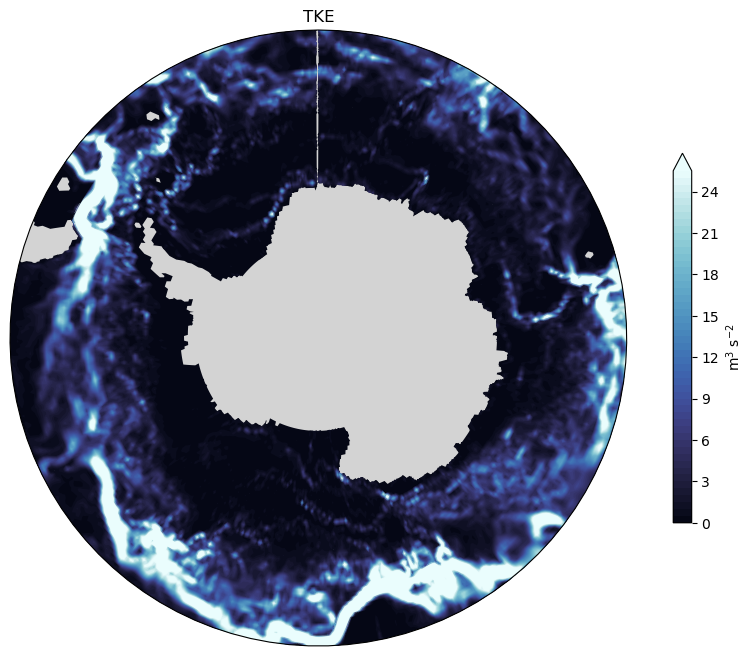

In [8]:

fig, axs = circumpolar_map()
iplt.contourf(TKE, levels=np.arange(0,26,0.5), extend='max', axes=axs, cmap = cm.cm.ice)
axs.set_title('TKE')
# set ticks..
plt.colorbar(label='m$^3$ s$^{-2}$', ticks=np.arange(0,26,5), shrink=0.6)

Snapshot plot of depth-integrated KE for a random time step:

In [ ]:
KE_snapshot = KEom2[0].collapsed('depth', iris.analysis.SUM, weights='cell_thickness')
KE_snapshot = regrid(KE_snapshot, '0.5x0.5', scheme='linear')
KE_snapshot.data.shape, KE_snapshot.summary(shorten=True)

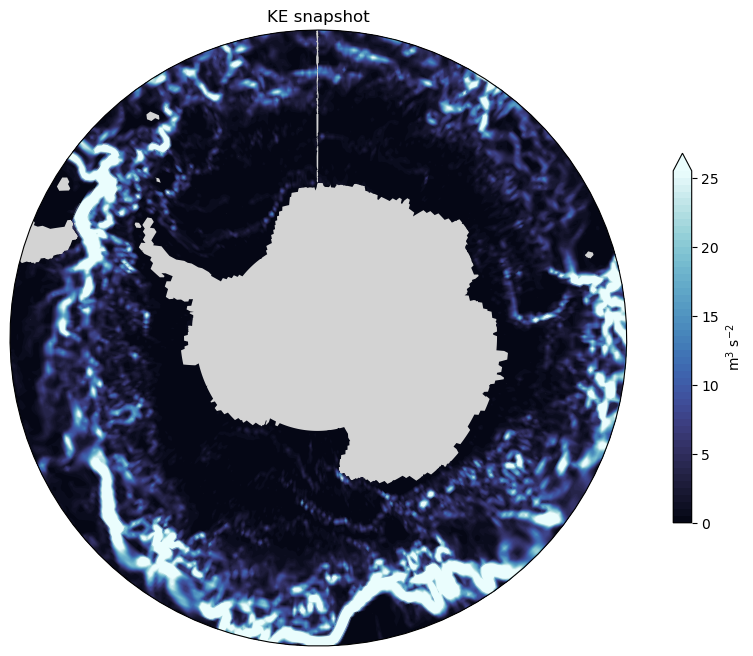

In [10]:
fig, axs = circumpolar_map()

iplt.contourf(KE_snapshot, levels=np.arange(0,26,0.5), extend='max', axes=axs, cmap = cm.cm.ice)
axs.set_title('KE snapshot')
plt.colorbar(label='m$^3$ s$^{-2}$',ticks=np.arange(0,26,5), shrink=0.6)
plt.show()

## Mean Kinetic Energy

For the mean kinetic energy, we need to average the velocities over time.

$$ {\rm MKE} = \frac{1}{2} \left( \bar{u}^2 + \bar{v}^2 \right). $$

In [6]:
u_mean = axis_statistics(uOM2, operator='mean', axis='t')
v_mean = axis_statistics(vOM2, operator='mean', axis='t')

MKE = 0.5*(u_mean**2 + v_mean**2)

# add cell_thickness supplementary variable
MKE = add_supplementary_variables(MKE, [thkcel])
MKE = MKE.collapsed('depth', iris.analysis.SUM, weights='cell_thickness')

In [8]:
MKE = regrid(MKE, '0.5x0.5', scheme='linear')
MKE.data.shape

(360, 720)

ERROR:tornado.application:Uncaught exception GET /individual-cpu/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='gadi-cpu-bdw-0124.gadi.nci.org.au:36430', method='GET', uri='/individual-cpu/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/tornado/web.py", line 1848, in _execute
    result = await result
             ^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/tornado/websocket.py", line 277, in get
    await self.ws_connection.accept_connection(self)
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/tornado/websocket.py", line 890, in accept_connection
    await self._accept_connection(handler)
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/tornado/websocket.py", line 973, in _accept_connection
    await 

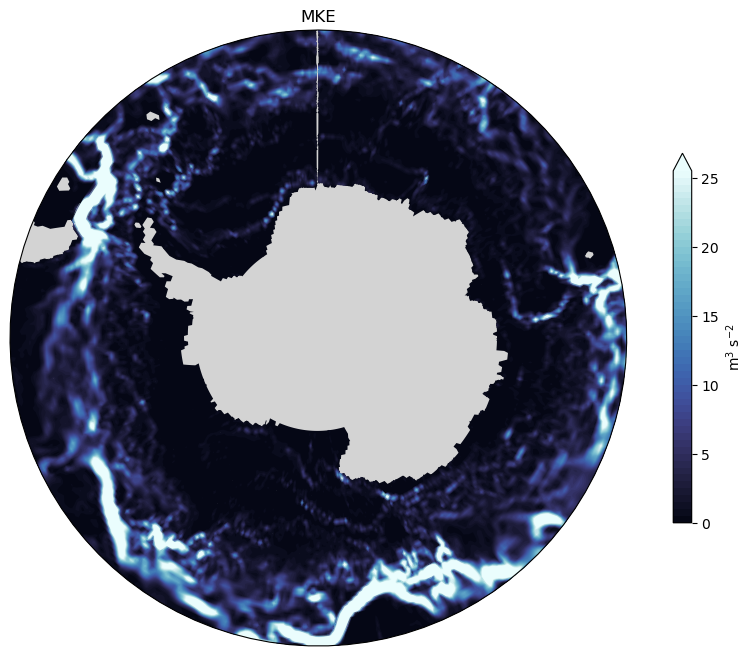

In [9]:
fig, axs = circumpolar_map()

iplt.contourf(MKE, levels=np.arange(0,26,0.5), extend='max', axes=axs, cmap = cm.cm.ice)
axs.set_title('MKE')
plt.colorbar(label='m$^3$ s$^{-2}$',ticks=np.arange(0,26,5), shrink=0.6)
plt.show()


## Eddy Kinetic Energy

We calculate the transient component of the velocity field and then compute the EKE:


$$ {\rm EKE} =  \overline{ \frac{1}{2} \left[ \left(u - \overline{u}\right)^2 + \left(v - \overline{v}\right)^2 \right] }. $$

In [21]:
u_transient = uOM2 - u_mean
v_transient = vOM2 - v_mean

EKE = 0.5*(u_transient**2 + v_transient**2)
EKE = add_supplementary_variables(EKE, [thkcel])
EKE = EKE.collapsed('depth', iris.analysis.SUM, weights='cell_thickness')
EKE = axis_statistics(EKE, operator='mean', axis='t')

In [22]:
EKE = regrid(EKE, '0.5x0.5', scheme='linear')
EKE.summary(shorten=True)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/numpy/ma/core.py:6980: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/numpy/ma/core.py:6980: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/numpy/ma/core.py:6980: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/numpy/ma/core.py:6980: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/numpy/ma/core.py:6980: RuntimeWarning: overflow

'unknown / (m3.s-2)                  (latitude: 360; longitude: 720)'

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 37.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


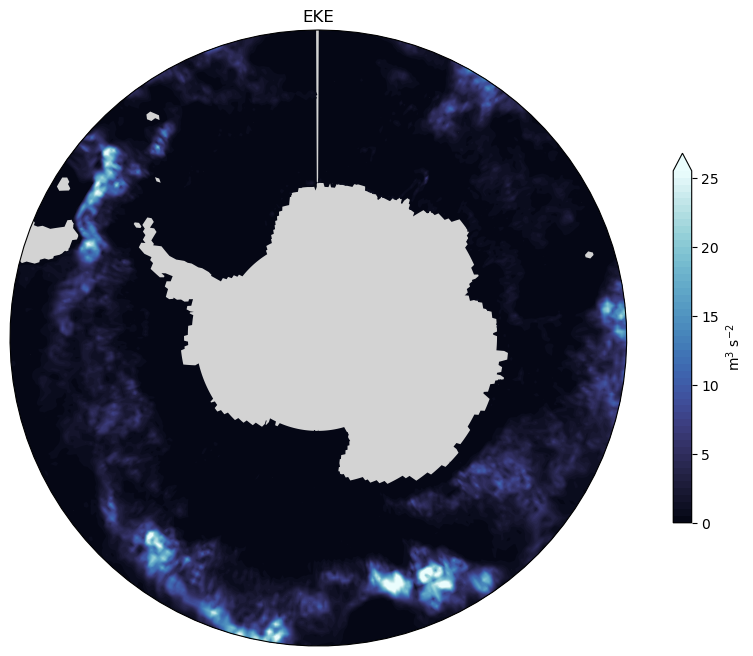

In [23]:
fig, axs = circumpolar_map()
iplt.contourf(EKE, levels=np.arange(0,26,0.5), extend='max', axes=axs, cmap = cm.cm.ice)
axs.set_title('EKE')
plt.colorbar(label='m$^3$ s$^{-2}$',ticks=np.arange(0,26,5), shrink=0.6)
plt.show()

In [ ]:
client.close()